In [570]:
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import plot_model, image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt

import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [541]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import pathlib
import cv2
import os

### Paths

In [542]:
images_path = '../../../Dataset/img_celeba_cropped'
identity_path = '../../../Dataset/identity_CelebA.txt'
attributes_path = '../../../Dataset/list_attr_celeba.txt'

### Hyperparameters

In [543]:
images_num=500

train_size=0.6
test_val_proportion=0.5

image_shape=(224, 224, 3)

batch_size=32
lr=0.01

## Creating pairs

In [544]:
celeb_identity = pd.read_csv(identity_path, sep = " ", names=["image", "identity"])
celeb_identity["identity"] = celeb_identity["identity"].astype("string")

celeb_attrs = pd.read_csv(attributes_path, sep = "\s+")

In [545]:
def get_balanced_pair(column:str, pairing_column:str, df=celeb_identity):
    # getting random identity from the provided column to use for balanced pair
    random_id = df[column].sample(1, replace=True).to_string(index=False)
    containing_id_list = df.loc[df[column] == random_id][pairing_column].sample(2, replace=True).to_list()
    
    # random pictures for pair generation
    df_without_id = df.loc[df[pairing_column] != random_id]
    negative = df[pairing_column].sample(1, replace=False).to_list()
    
    return [[containing_id_list[0], containing_id_list[1], 1], [containing_id_list[0], negative[0], 0]]

In [546]:
balanced_pairs = []

for record in range(images_num):
    pair = get_balanced_pair("identity", "image")
    balanced_pairs.append(pair[0])
    balanced_pairs.append(pair[1])
    
df = pd.DataFrame(balanced_pairs, columns =['left', 'right', 'label'])
df['left'] = images_path + '/' + df['left']
df['right'] = images_path + '/' + df['right']

In [547]:
df.shape
df.head()

,left,right,label
0,../../../Dataset/img_celeba_cropped/113363.jpg,../../../Dataset/img_celeba_cropped/031679.jpg,1
1,../../../Dataset/img_celeba_cropped/113363.jpg,../../../Dataset/img_celeba_cropped/015746.jpg,0
2,../../../Dataset/img_celeba_cropped/007048.jpg,../../../Dataset/img_celeba_cropped/150579.jpg,1
3,../../../Dataset/img_celeba_cropped/007048.jpg,../../../Dataset/img_celeba_cropped/024029.jpg,0
4,../../../Dataset/img_celeba_cropped/077353.jpg,../../../Dataset/img_celeba_cropped/096923.jpg,1


### Create test train val split

In [548]:
X_train, X_rem, y_train, y_rem = train_test_split(df.iloc[:,:-1], df.iloc[:,-1:], train_size=train_size, random_state = 101, shuffle=True)

X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=test_val_proportion)

In [549]:
print('=====Training=====')
print(X_train.shape)
print(y_train.shape)

print('=====Validation=====')
print(X_val.shape)
print(y_val.shape)

print('=====Testing=====')
print(X_test.shape)
print(y_val.shape)

=====Training=====
(600, 2)
(600, 1)
=====Validation=====
(200, 2)
(200, 1)
=====Testing=====
(200, 2)
(200, 1)


### Loading pairs into TF Dataset

In [550]:
def preprocessing(left, right):
    return convert_to_img(left), convert_to_img(right)


def convert_to_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    #img = tf.expand_dims(img, axis=0)
    img = tf.reshape(img,(224,224,3))
    return img

def label_preprocessing(label):
    return tf.cast(label, tf.float32)

In [551]:
def createDataset(features, labels):
    feature_ds = tf.data.Dataset.from_tensor_slices((features['left'].values, features['right'].values))
    labels_ds = tf.data.Dataset.from_tensor_slices(labels.values)
    
    feature_ds = feature_ds.map(preprocessing)
    labels_ds = train_label_dataset.map(label_preprocessing)
    
    dataset = tf.data.Dataset.zip((dataset_features, train_label_dataset))
    dataset = dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [556]:
train_ds = createDataset(X_train, y_train)
val_ds = createDataset(X_val, y_val)
test_ds = createDataset(X_test, y_test)

## NN model

In [558]:
left_input = layers.Input(shape=(224, 224, 3), name='left_input')
right_input = layers.Input(shape=(224, 224, 3), name='right_input')

### ResNet50 model

In [572]:
resnet_left=ResNet50(
    input_tensor=left_input,
    include_top=False,
    input_shape=image_shape,
    pooling='avg',
    weights='imagenet',
    classes=2)

for layer in resnet_left.layers[0:-1]:
    layer.trainable = False

    
output_layer_left = resnet_left.output
    
model_left = Model(left_input, outputs=output_layer_left, name='resnet50_1')

In [574]:
resnet_right=ResNet50(
    input_tensor=right_input,
    include_top=False,
    input_shape=image_shape,
    pooling='avg',
    weights='imagenet',
    classes=2)

for layer in resnet_right.layers[0:-1]:
    layer.trainable = False
    
for layer in resnet_right.layers:
    layer._name = layer.name + str('_2')

    
output_layer_right = resnet_right.output
    
model_right = Model(right_input, outputs=output_layer_right, name='resnet50_2')

### Merging resnet branches layers

In [575]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(tf.subtract(x, y)), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, K.epsilon()))

In [593]:
#merged = layers.subtract([model_left.output, model_right.output])
model = layers.Lambda(euclidean_distance, name="merge")([model_left.output, model_right.output])

model = layers.Flatten()(model)

model = layers.Dense(256, activation='relu')(model)
model = layers.Dropout(.2)(model)

model = layers.Dense(32, activation='relu')(model)

model = layers.Dense(1, activation='sigmoid')(model)

model = Model(inputs = [left_input, right_input], outputs = model)

In [594]:
# margin is a parametr settable by developer
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)    
    return contrastive_loss

In [595]:
model.compile(optimizer=Adam(learning_rate=lr), loss=contrastive_loss_with_margin(margin=1.0), metrics=['accuracy'])

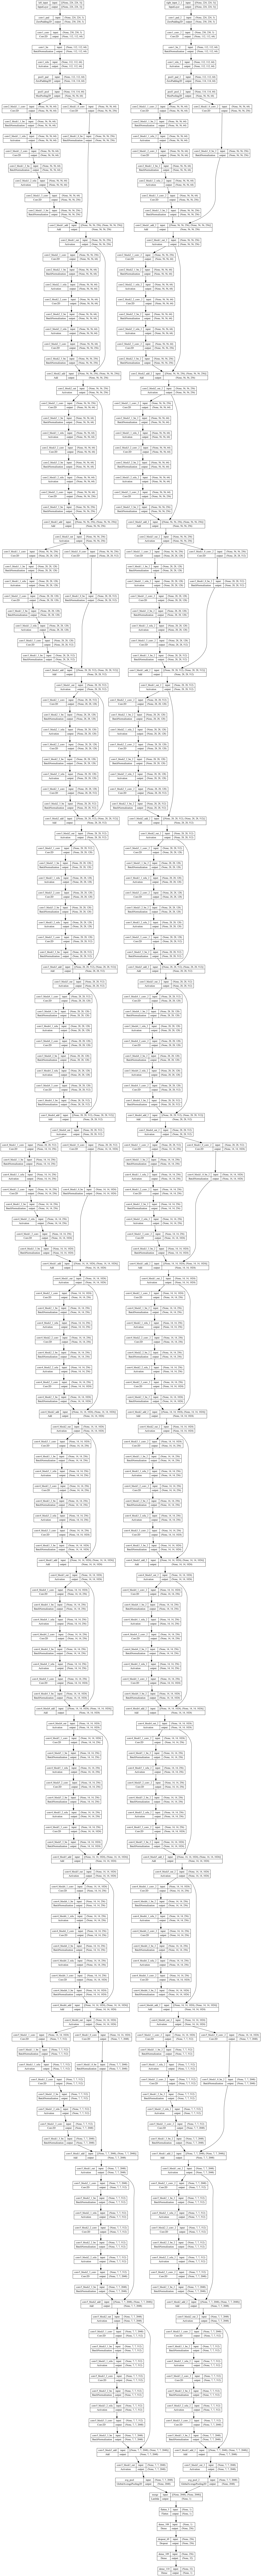

In [596]:
plot_model(model, show_shapes=True)
#model.summary()

In [597]:
model_fit = model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5


2022-11-27 01:25:13.409316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 0.1392 - accuracy: 0.1590

2022-11-27 01:25:25.497849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 25s 692ms/step - loss: 0.1392 - accuracy: 0.1590 - val_loss: 0.2929 - val_accuracy: 0.4740
Epoch 2/5
32/32 [==============================] - 17s 535ms/step - loss: 0.0016 - accuracy: 0.0000e+00 - val_loss: 0.3544 - val_accuracy: 0.4750
Epoch 3/5
32/32 [==============================] - 17s 527ms/step - loss: 1.3096e-04 - accuracy: 0.0000e+00 - val_loss: 0.3757 - val_accuracy: 0.4750
Epoch 4/5
32/32 [==============================] - 17s 534ms/step - loss: 8.4729e-05 - accuracy: 0.0000e+00 - val_loss: 0.3794 - val_accuracy: 0.4750
Epoch 5/5
32/32 [==============================] - 17s 533ms/step - loss: 6.4989e-05 - accuracy: 0.0000e+00 - val_loss: 0.3828 - val_accuracy: 0.4750


### Performance metrics

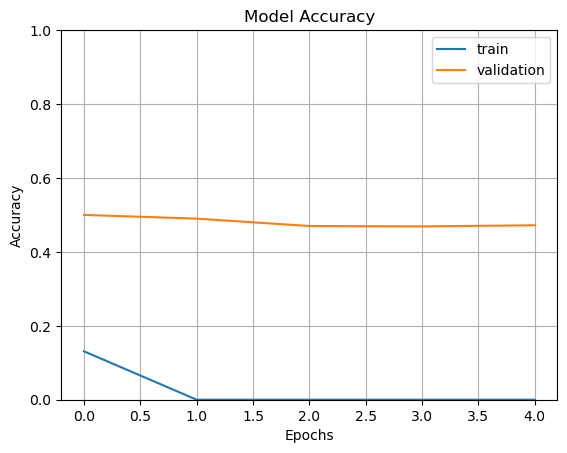

In [581]:
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.axis(ymin=0,ymax=1)
plt.grid()

plt.show()

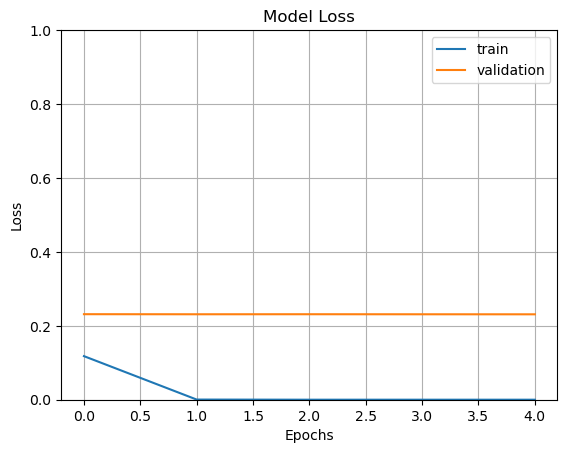

In [568]:
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.axis(ymin=0,ymax=1)
plt.grid()

plt.show()

### Predictions

In [ ]:
left_image_feature_vectors = model.predict(custom_img_left)
left_image_feature_vectors = model.predict(custom_img_right)